## 0.0 IMPORTS

In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import seaborn as sns; sns.set();
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import kurtosis, skew, norm
import math
import statistics
from scipy.stats import chi2
import pickle
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

pd.set_option('float_format', '{:.2f}'.format)

## 0.1 - HELPER FUNCTION (FUNÇÕES AUXILIARES)

In [2]:
def show_descriptive_statistical(df):
    # Central Tendency - mean, median
    ct1 = pd.DataFrame(df.apply(np.mean)).T
    ct2 = pd.DataFrame(df.apply(np.median)).T

    # Dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(df.apply(np.std)).T
    d2 = pd.DataFrame(df.apply(min)).T
    d3 = pd.DataFrame(df.apply(max)).T
    d4 = pd.DataFrame(df.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(df.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(df.apply(lambda x: x.kurtosis())).T

    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    return m

## 0.2 - PATH DEFINITION

In [3]:
HOME_PATH = '/home/valmir/Documentos/deteccao_fraude/'
RAW_DATA_PATH = 'data/raw/'
INTERIM_DATA_PATH = 'data/intermediario/'
FIGURE_PATH = 'reports/figures/'

## 0.3 - LOAD DATA

In [4]:
base_fraude_raw = pd.read_csv(HOME_PATH+RAW_DATA_PATH+'fraud_detection_dataset.csv')



## 1.0 - DATA DESCRIPITION

In [5]:
#base_fraude_raw1 = base_fraude_raw.copy()
#base_fraude_raw1.to_csv(HOME_PATH+INTERIM_DATA_PATH+'base_fraude_raw1.csv')
base_fraude_raw1 = pd.read_csv(HOME_PATH+INTERIM_DATA_PATH+'base_fraude_raw1.csv')


## 1.1 - DATA FIELD'S

Os dados contidos nesta base de dados são simulados e compreendem 30 dias. Estas transações podem ser de diferentes tipo e foram executadas via mobile devices. As features contidas nesta base de dados são:

 * `step` - Passo: representa o total de horas transcorrido desde o início da simulação. Esta feature vai variar entre 1 e 744(31
  dias);

 * `type`: Tipo: tipo de transação(depósito, saque, débito, pagamento e transferencia);

 * `amount`: Quantia: total que foi transacionado;

 * `nameOring`: ClienteOrigem: cliente que iniciou atransação;

 * `oldbalanceOrg`: SaldoInicialOrigem: saldo da conta de origem antes da transação;

 * `newbalanceOrig`: SaldoFinalOrigem: saldo da conta de origem depois da transação;

 * `nameDest`: ClienteDestino: cliente de destino da transação;

 * `oldbalandeDestino`: SaldoInicialDestino: saldo da conta destino antes da transação;

 * _`newbalanceDest`_: SaldoFinalDestino: saldo da conta destino depois da transação;

 * `isFraud`: Fraude: flag que define se a transação é fraudolenta ou não. Nesta simulação de fraude é a assumir se 'a conta do usuario foi   esvaziada e transferindo o dinherio para outra conta e depois sacado
 
 * `IssFlaggedFraud`: SinalizadaFraude: automaticamente categorizada como fraude pelo banco por fraude por tentar trasnferir mais de 200 mil em uma única conta


## 1.2 - RENAME COLUMNS

In [8]:
base_fraude_raw1.rename(columns={'step':'Tempo', 'type':'Tipo', 'amount': 'Quantia',
                                'nameOrig':'ClienteOrigem', 'oldbalanceOrg': 'SaldoInicalOrig',
                                'newbalanceOrig':'SaldoFinalOrig', 'nameDest':'ClienteDest',
                                'oldbalanceDest':'SaldoInicialDest', 'newbalanceDest':'SaldoFinalDest',
                                'isFraud':'Fraude', 'isFlaggedFraud':'SinalizadaFraude'}, inplace=True)


## 1.3 - DATA DIMENSIONS

In [1]:
num_linhas, num_colunas = base_fraude_raw1.shape

print('Numero de linhas', num_linhas)
print('Numero de colunas', num_colunas)

NameError: name 'base_fraude_raw1' is not defined

## 1.4 - DATA TYPES

In [9]:
#base_fraude_categoria = base_fraude_raw1[['Tipo','ClienteDest', 'ClienteOrigem']].astype('category')
base_fraude_raw1.dtypes

Unnamed: 0            int64
Tempo                 int64
Tipo                 object
Quantia             float64
ClienteOrigem        object
SaldoInicalOrig     float64
SaldoFinalOrig      float64
ClienteDest          object
SaldoInicialDest    float64
SaldoFinalDest      float64
Fraude                int64
SinalizadaFraude      int64
dtype: object

## 1.5 CHANGE TYPE

#### Não houve nenhuma mudança nos tipos de variaveis nessa etapa, pois todas as features se encontravam com seus tipos bem definidos

## 1.6 - CHECK N.A.

### Não foi encontrado nenhum valor nulo nesse Dataset

In [10]:
base_fraude_raw1.isnull().sum()

Unnamed: 0          0
Tempo               0
Tipo                0
Quantia             0
ClienteOrigem       0
SaldoInicalOrig     0
SaldoFinalOrig      0
ClienteDest         0
SaldoInicialDest    0
SaldoFinalDest      0
Fraude              0
SinalizadaFraude    0
dtype: int64

In [10]:
base_fraude_raw1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 12 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Unnamed: 0        int64  
 1   Passos            int64  
 2   Tipo              object 
 3   Quantia           float64
 4   ClienteOrigem     object 
 5   SaldoInicalOrig   float64
 6   SaldoFinalOrig    float64
 7   ClienteDest       object 
 8   SaldoInicialDest  float64
 9   SaldoFinalDest    float64
 10  Fraude            int64  
 11  SinalizadaFraude  int64  
dtypes: float64(5), int64(4), object(3)
memory usage: 582.5+ MB


## 1.7 - FILL OUT N.A.

### Não havendo nenhum valor faltante nesse Dataset, não foi nescessario nenhum metodo de preenchimento ou exclusão dos mesmos

## 1.8 DISCRIPTIVE STATISTICAL

In [11]:
num_attributes = base_fraude_raw1.select_dtypes(include=['int64', 'float64'])
cat_attributes = base_fraude_raw1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])



Medidas de tendencia central - 
 - Media
 - Mediana
 

Medidas de Dispersão

- Skewness
- Kurtosis
- Desvio Padrão
- Range (alcance)
- Min
- Max

### 1.8.1 - NUMERIC ESTATISTIC

In [12]:
m = show_descriptive_statistical(num_attributes)
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,Unnamed: 0,0.000,6362619.000,6362619.000,3181309.500,3181309.500,1836730.185,0.000,-1.200
1,Tempo,1.000,743.000,742.000,243.397,239.000,142.332,0.375,0.329
2,Quantia,0.000,92445516.640,92445516.640,179861.904,74871.940,603858.184,30.994,1797.957
3,SaldoInicalOrig,0.000,59585040.370,59585040.370,833883.104,14208.000,2888242.446,5.249,32.965
4,SaldoFinalOrig,0.000,49585040.370,49585040.370,855113.669,0.000,2924048.273,5.177,32.067
5,SaldoInicialDest,0.000,356015889.350,356015889.350,1100701.667,132705.665,3399179.846,19.922,948.674
6,SaldoFinalDest,0.000,356179278.920,356179278.920,1224996.398,214661.440,3674128.653,19.352,862.157
7,Fraude,0.000,1.000,1.000,0.001,0.000,0.036,27.780,769.703
8,SinalizadaFraude,0.000,1.000,1.000,0.000,0.000,0.002,630.604,397659.062


In [13]:
base_fraude_raw1.tail()

,Unnamed: 0,Passos,Tipo,Quantia,ClienteOrigem,SaldoInicalOrig,SaldoFinalOrig,ClienteDest,SaldoInicialDest,SaldoFinalDest,Fraude,SinalizadaFraude
6362615,6362615,743,CASH_OUT,339682.130,C786484425,339682.130,0.000,C776919290,0.000,339682.130,1,0
6362616,6362616,743,TRANSFER,6311409.280,C1529008245,6311409.280,0.000,C1881841831,0.000,0.000,1,0
6362617,6362617,743,CASH_OUT,6311409.280,C1162922333,6311409.280,0.000,C1365125890,68488.840,6379898.110,1,0
6362618,6362618,743,TRANSFER,850002.520,C1685995037,850002.520,0.000,C2080388513,0.000,0.000,1,0
6362619,6362619,743,CASH_OUT,850002.520,C1280323807,850002.520,0.000,C873221189,6510099.110,7360101.630,1,0


### 1.8.2 - CATEGORICAL ATRIBUTES



In [13]:
cat_attributes.apply(lambda x: x.unique().shape[0])

Tipo                   5
ClienteOrigem    6353307
ClienteDest      2722362
dtype: int64

## 2.0 - FEATURE ENGINEERING- PARTE I

In [11]:
#base_fraude_raw2 = base_fraude_raw1.copy()
#base_fraude_raw2.to_csv(HOME_PATH+INTERIM_DATA_PATH+'base_fraude_raw2.csv')
base_fraude_raw2 = pd.read_csv(HOME_PATH+INTERIM_DATA_PATH+'base_fraude_raw2.csv')

## 2.1 - MAPA MENTAL DE HIPOTESE

![MapaMental de Hipotese]
(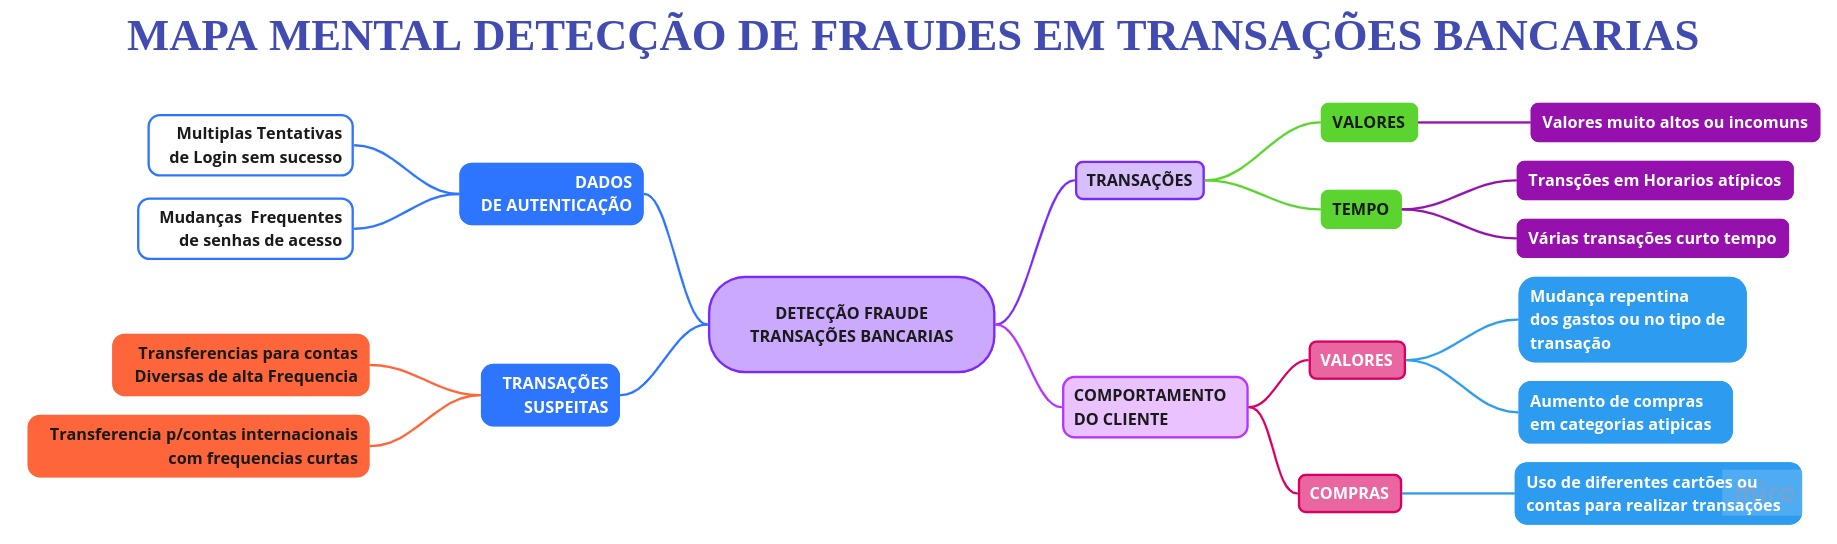)


## 2.2 - CRIAÇÃO DAS HIPOTESE

### TRANSAÇÕES 
 * QUANDO OS VALORES DAS TRANSAÇÕES FOREM MUITO ALTOS OU INCOMUNS EM RELAÇÃO AOS PADRÕES COMUNS DO CLIENTE, SERAM CLASSIFICADOS COMO FRAUDES;

 * QUANDO AS TRANSAÇÕES FOREM REALIZADAS EM HORÁRIOS ATÍPICOS AOS PADRÕES COMUNS REALIZADAS PELO CLIENTE, SERAM CLASSIFICADOS COMO FRAUDES;

 * QUANDO AS TRANSAÇÕES FOREM REALIZADAS EM MOMENTOS DE TEMPO MUITO CURTOS, SERAM CLASSIFICADOS COMO FRAUDES; 

 ### COMPORTAMENTO DO CLIENTE
 * QUANDO HOUVER MUDANÇAS REPENTINAS DOS VALORES DOS GASTOS E/OU DA FORMA DE TRANSAÇÃO TÍPICA DO CLIENTE, SERAM CLASSIFICADOS COMO FRAUDES;

 * QUANDO AS TRANSAÇÕES MUDAREM REPENTINAMENTE DO TIPO DA CATEGORIA QUE O CLIENTE EVENTUALMENTE REALIZA, SERAM CLASSIFICADOS COMO FRAUDES;

 * QUANDO HOUVER A TROCA DESORDENADA DO CARTÃO QUE O CLIENTE UTILIZA EVENTUALMENTE EM SUAS TRANSAÇÕES, SERAM CLASSIFICADOS COMO FRAUDES;

 ### DADOS DE AUTENTICAÇÃO
 * QUANDO HOUVER MULTIPLAS TENTATIVAS ERRADAS, SOLICITAÇÃO DE NOVA SENHA ANTES DO CLIENTE CONSEGUIR LOGAR, SERAM CLASSIFICADOS COMO FRAUDES;
 
 ### TRANSAÇÕES SUSPEITAS
 * QUANDO HOUVER TRANSFERENCIAS PARA CONTAS DIVERSAS DAS HABITUAIS REALIZADAS PELO CLIENTE, SERAM CLASSIFICADOS COMO FRAUDES;
 
 * QUANDO HOUVER TRANSFERENCIAS PARA CONTAS INTERNACIONAIS COM FREQUENCIAS DE CURTO ESPAÇO DE TEMPO, SERAM CLASSIFICADOS COMO FRAUDES;


## 2.3 - LISTA FINAL DE HIPOTESE

### TRANSAÇÕES 
 * QUANDO OS VALORES DAS TRANSAÇÕES FOREM MAIORES QUE 50% DO SALDO INICIAL, SERAM CLASSIFICADOS COMO FRAUDES;

 * QUANDO AS TRANSAÇÕES FOREM REALIZADAS EM MOMENTOS DE TEMPO MUITO CURTOS, SERAM CLASSIFICADOS COMO FRAUDES; 

 ### COMPORTAMENTO DO CLIENTE
 * OS CLIENTES QUE TIVEREM PODER AQUISITIVO ALTO, ONDE A MEDIA SALARIAL AMERICA CONSTADA É DE $ 3.800,00, SERAM CLASSIFICADOS COMO FRAUDES;

 ### TRANSAÇÕES SUSPEITAS
 * APÓS CLASSIFICADOS OS TIPOS CLIENTES DE ORIGEM E CLIENTES DE DESTINO DE C PARA CLIENTES COMUNS E M PARA ORGANIZAÇÕES, AS TRANSAÇÕES SUSPEITAS QUE CONSIDRERAM COMO FRAUDES SERÃO AS DE CLIENTES PARA CLIENTES;
 
 

## 2.4 - FEATURE ENGINEERING - PARTE 1

In [15]:
base_fraude_raw2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 13 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Unnamed: 0.1      int64  
 1   Unnamed: 0        int64  
 2   Passos            int64  
 3   Tipo              object 
 4   Quantia           float64
 5   ClienteOrigem     object 
 6   SaldoInicalOrig   float64
 7   SaldoFinalOrig    float64
 8   ClienteDest       object 
 9   SaldoInicialDest  float64
 10  SaldoFinalDest    float64
 11  Fraude            int64  
 12  SinalizadaFraude  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 631.1+ MB


`TRANSAÇÕES FOREM MAIORES QUE 50% DO SALDO INICIAL? `

Criei uma Feature chamada "MAIOR_50%" para classificar como yes e no para transações acima de 50% do Saldo Original;

`PODER AQUISITIVO DOS CLIENTES? ` 

Criei uma Feature chamada "PODER_COMPRA" para classificar como ALTA, MÉDIO E BAIXA o poder aquisitivo dos clientes baseado na média salarial americana que seria de $3.800,00 sobre o saldo inicial dos clientes;

`TRANSAÇÕES FOREM MAIORES QUE 50% DO SALDO INICIAL? ` 

Criei uma Feature chamada "TIPO_TRANSACAO" para classificar como C e M, onde C seriam clientes comuns e M seriam clientes organizacionais.

In [12]:
base_fraude_raw2['maior_50%'] = base_fraude_raw2[['Quantia', 'SaldoInicalOrig']].apply(
    lambda x: 'yes' if x['Quantia'] / 2 > x['SaldoInicalOrig'] else 'no', axis=1)


base_salarial = 3800
media_salarial = base_fraude_raw2['SaldoInicalOrig'].median()

base_fraude_raw2['poder_compra'] = base_fraude_raw2['SaldoInicalOrig'].apply(
    lambda x: 'baixa' if x <= base_salarial else 'medio'
                      if x > base_salarial and x <= media_salarial else 'alta')


base_fraude_raw2['tipo_transacao'] = base_fraude_raw2[['ClienteOrigem', 'ClienteDest']].apply(
    lambda x: 'C para C' if x['ClienteOrigem'][0] == 'C' and x['ClienteDest'][0] == 'C' else 'M para M'
                         if x['ClienteOrigem'][0] == 'M' and x['ClienteDest'][0] == 'M' else 'C para M'
                         if x['ClienteOrigem'][0] == 'C' and x['ClienteDest'][0] == 'M' else 'M para C'
                         if x['ClienteOrigem'][0] == 'M' and x['ClienteDest'][0] == 'C' else None, axis=1)

In [9]:
base_fraude_raw2.head()

,Unnamed: 0.1,Unnamed: 0,Passos,Tipo,Quantia,ClienteOrigem,SaldoInicalOrig,SaldoFinalOrig,ClienteDest,SaldoInicialDest,SaldoFinalDest,Fraude,SinalizadaFraude,maior_50%,poder_compra,tipo_transacao
0,0,0,1,PAYMENT,9839.640,C1231006815,170136.000,160296.360,M1979787155,0.000,0.000,0,0,no,alta,C para M
1,1,1,1,PAYMENT,1864.280,C1666544295,21249.000,19384.720,M2044282225,0.000,0.000,0,0,no,alta,C para M
2,2,2,1,TRANSFER,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,1,0,no,baixa,C para C
3,3,3,1,CASH_OUT,181.000,C840083671,181.000,0.000,C38997010,21182.000,0.000,1,0,no,baixa,C para C
4,4,4,1,PAYMENT,11668.140,C2048537720,41554.000,29885.860,M1230701703,0.000,0.000,0,0,no,alta,C para M


## 3.0 - FILTRAGEM DE VARIAVEIS 

In [12]:
"""base_fraude_raw3 = base_fraude_raw2.copy()
base_fraude_raw3.to_csv(HOME_PATH+INTERIM_DATA_PATH+'base_fraude_raw3.csv')"""
base_fraude_raw3 = pd.read_csv(HOME_PATH+INTERIM_DATA_PATH+'base_fraude_raw3.csv')

## 3.1 - FILTRAGEM DE LINHAS 
Devido termos poucas colunas a quantidade de linhas farão toda a diferença, visto que não possuimos valores nulos e o valores `0` em algumas 

linhas são afirmações de `NÃO TRANSAÇÃO`, impactando assim, diretamente nos resultados finais.

## 3.2 - FILTRAGEM DE COLUNAS - SELEÇÃO DAS COLUNAS

Devido termos poucas colunas a quantidade de linhas farão toda a diferença, visto que não possuimos valores nulos e o valores `0` em algumas 

linhas são afirmações de `NÃO TRANSAÇÃO`, impactando assim, diretamente nos resultados finais.

In [11]:
base_fraude_raw3.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Passos,Tipo,Quantia,ClienteOrigem,SaldoInicalOrig,SaldoFinalOrig,ClienteDest,SaldoInicialDest,SaldoFinalDest,Fraude,SinalizadaFraude,maior_50%,poder_compra,tipo_transacao
0,0,0,0,1,PAYMENT,9839.640,C1231006815,170136.000,160296.360,M1979787155,0.000,0.000,0,0,no,alta,C para M
1,1,1,1,1,PAYMENT,1864.280,C1666544295,21249.000,19384.720,M2044282225,0.000,0.000,0,0,no,alta,C para M
2,2,2,2,1,TRANSFER,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,1,0,no,baixa,C para C
3,3,3,3,1,CASH_OUT,181.000,C840083671,181.000,0.000,C38997010,21182.000,0.000,1,0,no,baixa,C para C
4,4,4,4,1,PAYMENT,11668.140,C2048537720,41554.000,29885.860,M1230701703,0.000,0.000,0,0,no,alta,C para M


In [13]:
del base_fraude_raw3['Unnamed: 0']
del base_fraude_raw3['Unnamed: 0.1']
del base_fraude_raw3['Unnamed: 0.2']

## 4.0 - ANALISE E VISUALIZAÇÕES

In [14]:
"""dtype = {'Passos':'category',
         'Tipo':'category',
         'Quantia':'float32',
         'SaldoInicalOrig':'float32',
         'SaldoFinalOrig':'float32',
         'SaldoInicialDest':'float32',
         'SaldoFinalDest':'float32',
         'Fraude': 'int32',
         'SinalizadaFraude':'int32',
         'FreqCliente':'int32'}

base_fraude_raw4 = base_fraude_raw3.copy()
base_fraude_raw4.to_csv(HOME_PATH+INTERIM_DATA_PATH+'base_fraude_raw4.csv')"""
base_fraude_raw4 = pd.read_csv(HOME_PATH+INTERIM_DATA_PATH+'base_fraude_raw4.csv')

In [15]:
del base_fraude_raw4['Unnamed: 0']
base_fraude_raw4.head()

,Passos,Tipo,Quantia,ClienteOrigem,SaldoInicalOrig,SaldoFinalOrig,ClienteDest,SaldoInicialDest,SaldoFinalDest,Fraude,SinalizadaFraude,maior_50%,poder_compra,tipo_transacao
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,no,alta,C para M
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,no,alta,C para M
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,no,baixa,C para C
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,no,baixa,C para C
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,no,alta,C para M


In [16]:
base_fraude_raw4.memory_usage().sum() / 1024**2

679.6012573242188

In [18]:
"""with open('base_fraude_reduz.pkl', mode = 'wb') as f:
    pickle.dump(base_fraude_raw4,f)"""

In [19]:
"""with open('base_fraude_reduz.pkl', 'rb') as f:
    base_fraude_raw4 = pickle.load(f)"""

In [17]:
"""ANALISAMOS QUE A FORMA DE PAGAMENTO QUE MAIS POSSUI FRAUDES SÃO CASH_OUT E TRANSFER.
SABENDO DISSO, REDUZIMOS O DATASET APENAS PARA AS TRANSAÇÕES DE CASH_OUT E TRANSFER
QUE SÃO CONSIDERADAS FRAUDES. COM ISSO, NÃO DESPREZAMOS AS TRANSAÇÕES QUE NÃO SÃO
FRAUDES."""

"""base_fraude_real = base_fraude_raw4[base_fraude_raw4['Fraude'] == 1]"""
tipos_fraude = ["CASH_OUT", "TRANSFER"]
base_fraude_real = base_fraude_raw4[base_fraude_raw4['Tipo'].isin(tipos_fraude)]
base_fraude_real.head()

,Passos,Tipo,Quantia,ClienteOrigem,SaldoInicalOrig,SaldoFinalOrig,ClienteDest,SaldoInicialDest,SaldoFinalDest,Fraude,SinalizadaFraude,maior_50%,poder_compra,tipo_transacao
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,no,baixa,C para C
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,no,baixa,C para C
15,1,CASH_OUT,229133.94,C905080434,15325.00,0.00,C476402209,5083.00,51513.44,0,0,yes,alta,C para C
19,1,TRANSFER,215310.30,C1670993182,705.00,0.00,C1100439041,22425.00,0.00,0,0,yes,baixa,C para C
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.00,C932583850,6267.00,2719172.89,0,0,yes,medio,C para C


In [18]:
base_fraude_real.memory_usage().sum() / 1024**2

317.0481491088867

In [19]:
# Dividir a base de dados em treino, validação e teste usando amostragem estratificada
X = base_fraude_real.drop('Tipo', axis=1)  # Variáveis preditoras
y = base_fraude_real['Tipo']  # Variável alvo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train, random_state=42)

In [23]:
# Verificar o tamanho dos conjuntos de treino, validação e teste
print("Tamanho do conjunto de treino:", len(X_train))
print("Tamanho do conjunto de validação:", len(X_val))
print("Tamanho do conjunto de teste:", len(X_test))

Tamanho do conjunto de treino: 2001619
Tamanho do conjunto de validação: 353228
Tamanho do conjunto de teste: 415562


In [20]:
with open('X_train1.pkl', mode = 'wb') as f:
    pickle.dump(X_train,f)

In [6]:
with open('X_train1.pkl', 'rb') as f:
    X_train = pickle.load(f)

In [7]:
X_train.memory_usage().sum() / 1024**2

213.7959747314453

In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2001619 entries, 1536742 to 4457850
Data columns (total 13 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Passos            int64  
 1   Quantia           float64
 2   ClienteOrigem     object 
 3   SaldoInicalOrig   float64
 4   SaldoFinalOrig    float64
 5   ClienteDest       object 
 6   SaldoInicialDest  float64
 7   SaldoFinalDest    float64
 8   Fraude            int64  
 9   SinalizadaFraude  int64  
 10  maior_50%         object 
 11  poder_compra      object 
 12  tipo_transacao    object 
dtypes: float64(5), int64(3), object(5)
memory usage: 213.8+ MB


In [9]:
X_train.head()

,Passos,Quantia,ClienteOrigem,SaldoInicalOrig,SaldoFinalOrig,ClienteDest,SaldoInicialDest,SaldoFinalDest,Fraude,SinalizadaFraude,maior_50%,poder_compra,tipo_transacao
1536742,154,230866.27,C1043817966,34802.00,0.00,C262266476,135416.12,366282.39,0,0,yes,alta,C para C
2986614,231,308860.13,C807194438,136240.00,0.00,C1423374426,33895.27,415027.19,0,0,yes,alta,C para C
5105980,355,94526.70,C1168306301,71730.00,0.00,C1720721903,5500393.88,5594920.58,0,0,no,alta,C para C
934675,43,223562.90,C1238179313,0.00,0.00,C649468405,1995496.08,2219058.98,0,0,yes,baixa,C para C
2596959,208,100159.31,C594201629,417954.06,317794.74,C1643112559,1203404.74,1303564.05,0,0,no,alta,C para C


In [10]:
num_attributes = X_train.select_dtypes(include=['int64', 'float64'])
cat_attributes = X_train.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 4.1 - Análise e Visualização Univariada

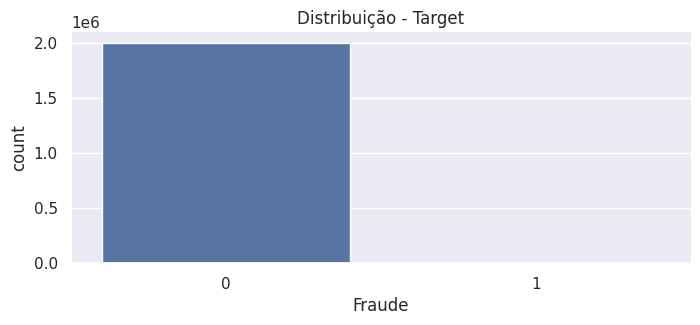

In [12]:
# Figure 
plt.figure(figsize=(8, 3))
sns.countplot(x='Fraude', data=X_train, palette=None)
sns.despine(right=True)
plt.title('Distribuição - Target');

### 4.2 - Análise e Visualização Bivariada

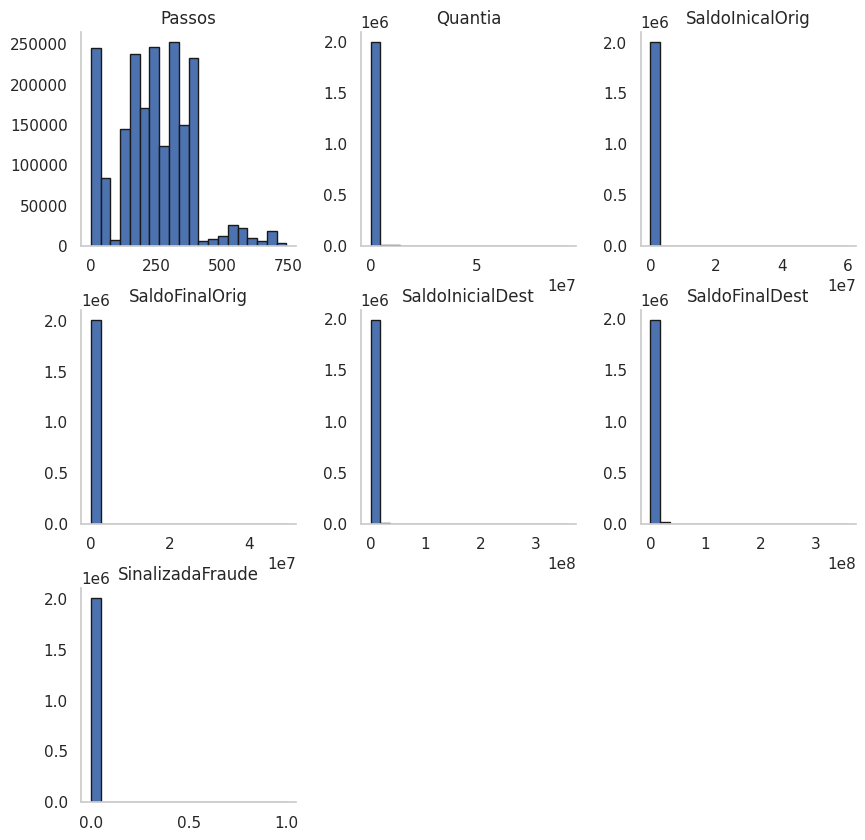

In [38]:
# Filter numerical atributes
num = X_train.select_dtypes(include=['int64', 'float64']).drop(columns=['Fraude'])

# Figure
num.hist(grid=False, bins=20, ec='k', figsize=(10, 10))
sns.despine(right=True)
plt.title('Dsitribuição Variaveis Numéricas');

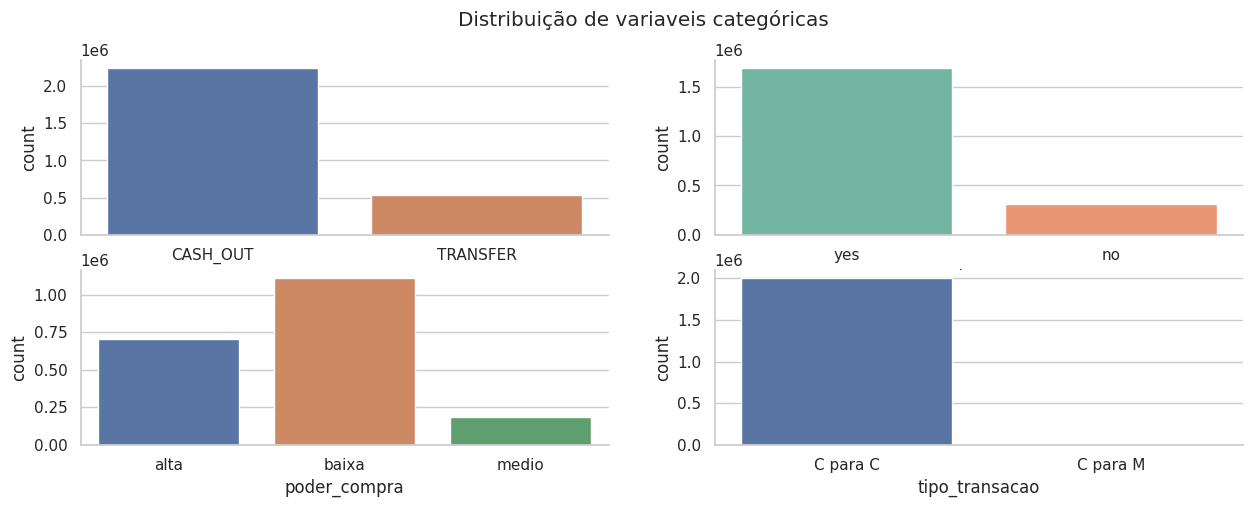

In [28]:
# Filter categorical atributes
cat = X_train.select_dtypes(include=['object'])

# Figure 1
plt.figure(figsize=(15, 5))
plt.subplot(2, 2, 1)
sns.countplot(x='Tipo', data=base_fraude_real, order=list(base_fraude_real['Tipo'].value_counts().sort_values(ascending=False).index), palette= None)
plt.suptitle('Distribuição de variaveis categóricas')
sns.despine(right=True)
# Figure 2
plt.subplot(2, 2, 2)
sns.countplot(x='maior_50%', data=cat, order=['yes', 'no'], palette= "Set2")
sns.despine(right=True)

# Figure 3
plt.subplot(2, 2, 3)
sns.countplot(x='poder_compra', data=cat, palette=None)
sns.despine(right=True)

# Figure 4
plt.subplot(2, 2, 4)
sns.countplot(x='tipo_transacao', data=cat, order=['C para C', 'C para M'], palette=None)
sns.despine(right=True);

`Insight:` 
* Com a base reduzida, analisando as transações fraudulentas, percebemos que os tipos de transações com maior numero de casos são CASH_OUT e TRANSFERENCIA.
* Com a base reduzida, analisando o saldo inicial, constatamos que a maioria das pessoas realisam as transações maiores que 50% do valor delas em seus saldos iniciais.
* Com a base reduzida, analisando o poder de compra, pela media salarial de $ 3.800,00, é baixo o poder aquisitivo.
* Com a base reduzida, conseguimos categorizar o tipo de transação entre clientes e empresas e a grande maioria das fraudes são realizadas de clientes para clientes.

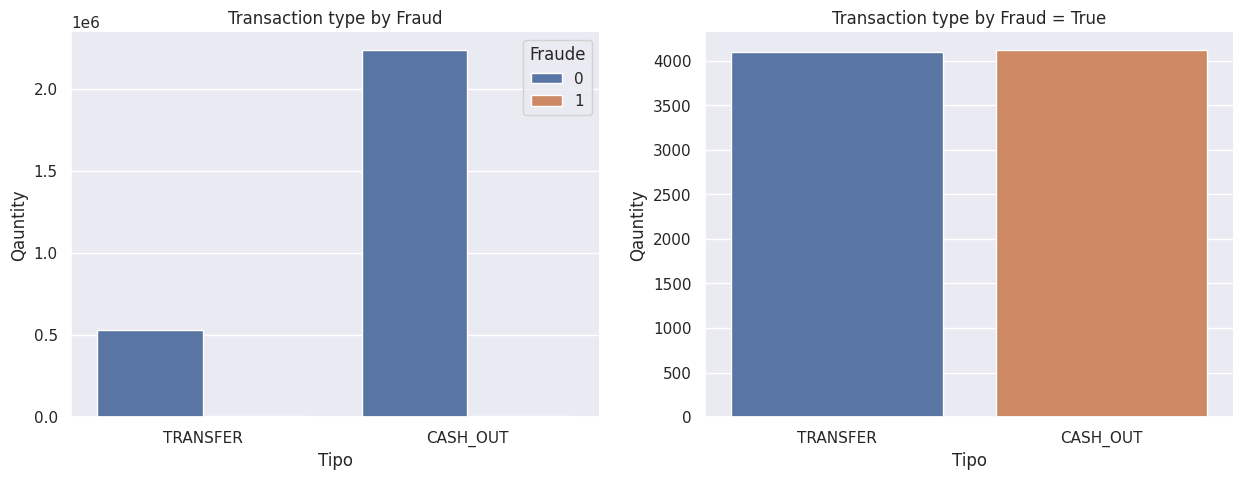

In [27]:
# figure 1
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='Tipo', data=base_fraude_real, hue='Fraude', palette=None)
plt.ylabel('Qauntity')
plt.title('Transaction type by Fraud')
sns.despine(right=True)

# figure 2
plt.subplot(1, 2, 2)
filter_fraud = base_fraude_real[base_fraude_real['Fraude'] == 1]
sns.countplot(x='Tipo', data=filter_fraud, palette=None)
plt.ylabel('Qauntity')
plt.title('Transaction type by Fraud = True')
sns.despine(right=True);

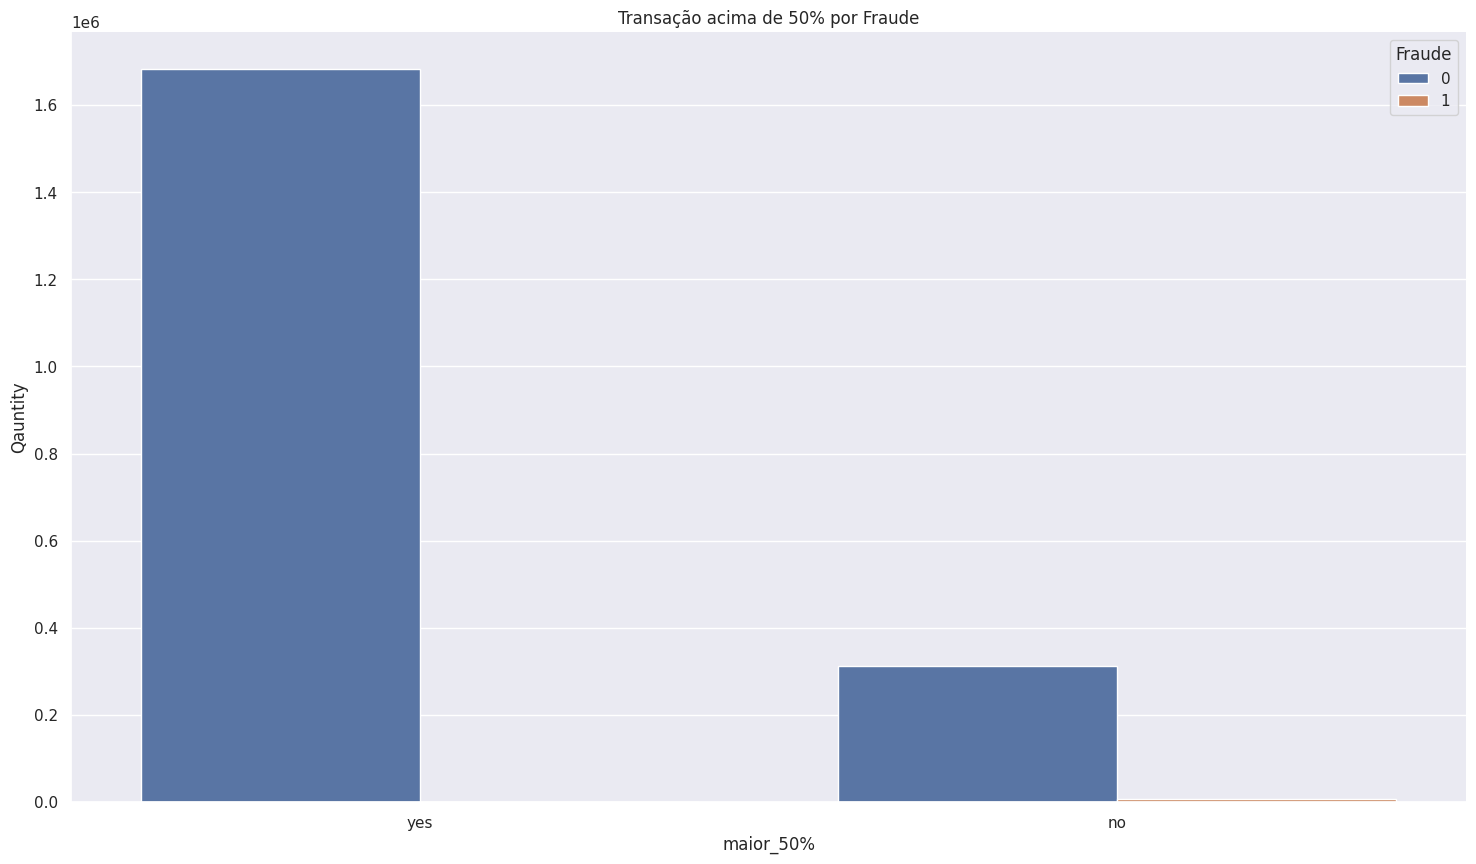

In [58]:
plt.figure(figsize=(18, 10))
sns.countplot(x='maior_50%', data=X_train, hue='Fraude', palette=None)
plt.ylabel('Qauntity')
plt.title('Transação acima de 50% por Fraude')
sns.despine(right=True);


* Verifiamos que as transações maiores que 50% do Saldo Inicial NÃO são fraudes

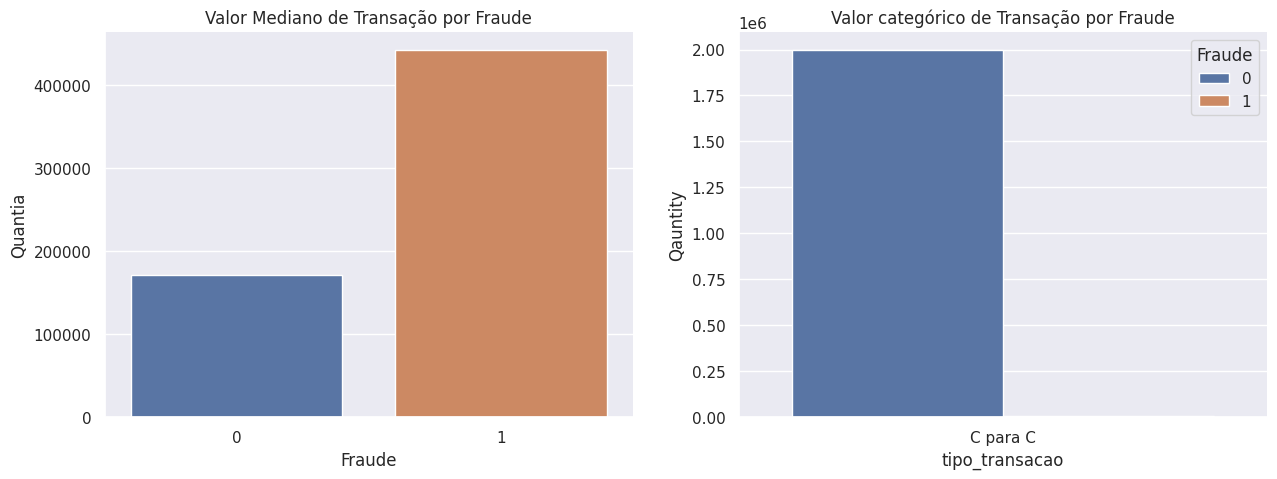

In [29]:
median_group = X_train['Quantia'].groupby(X_train['Fraude']).median().reset_index()

# Figure 1
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.barplot(x='Fraude', y='Quantia', data=median_group, palette=None)
plt.title('Valor Mediano de Transação por Fraude')
sns.despine(right=True)

# Figure 2
plt.subplot(1, 2, 2)
sns.countplot(x='tipo_transacao', data=X_train, hue='Fraude', palette=None)
plt.ylabel('Qauntity')
plt.title('Valor categórico de Transação por Fraude')
sns.despine(right=True);

* Percebemos que as fraudes, possui em seu maios valor $200.000,00(duzentos mil) e a maioria de Transações normais são de Cliente para Cliente

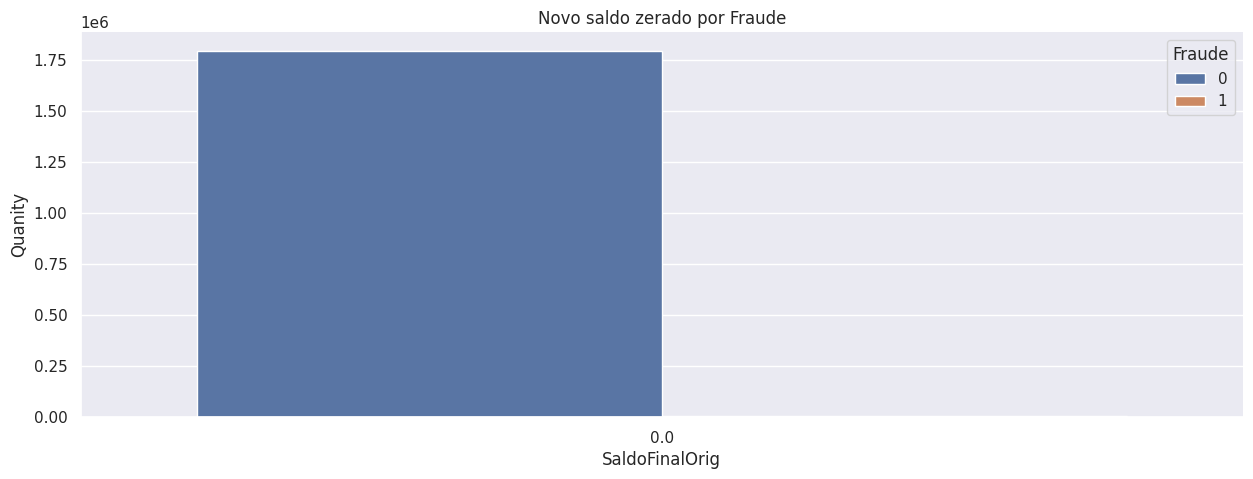

In [31]:
novovalor_orig_zero = X_train[X_train['SaldoFinalOrig'] == 0]

plt.figure(figsize=(15, 5))
sns.countplot(x='SaldoFinalOrig', data=novovalor_orig_zero, hue='Fraude', palette=None)
plt.ylabel('Quanity')
plt.title('Novo saldo zerado por Fraude')
sns.despine(right=True);

* Interpretamos acima, que o saldo final zerado, como se tirasse tudo depois da fraude, teoria essa apresentada pela a empresa responsavel pelos dados que os classificam Fraude ou Não, não caracteriza Fraude

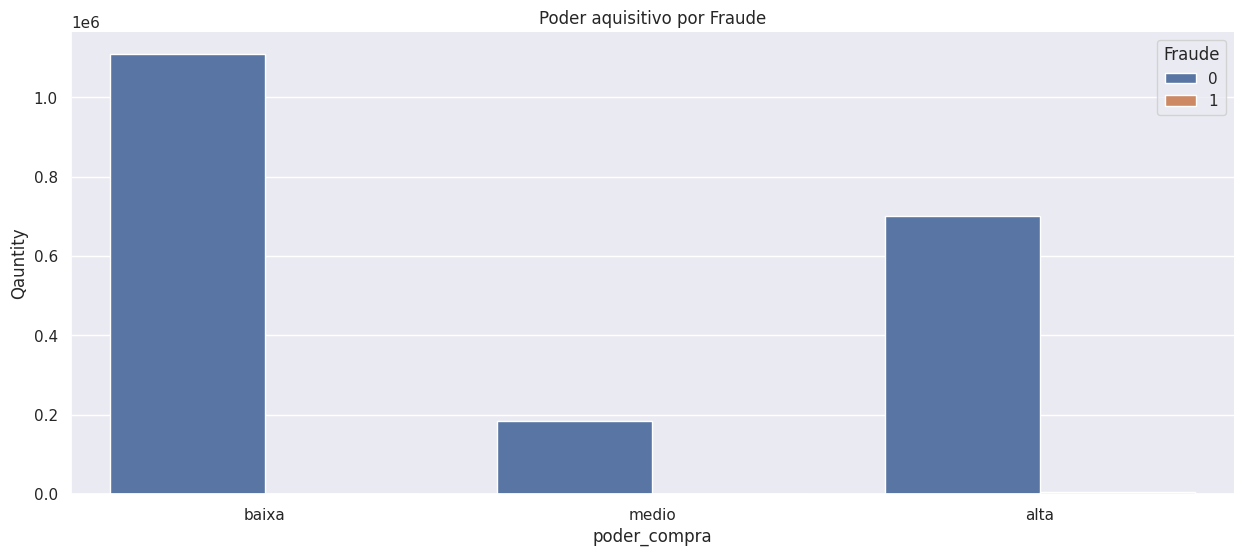

In [59]:
plt.figure(figsize=(15, 6))
sns.countplot(x='poder_compra', data=X_train, hue='Fraude', order=['baixa', 'medio', 'alta'], palette=None)
plt.title('Poder aquisitivo por Fraude')
plt.ylabel('Qauntity')
sns.despine(right=True);

* Percebemos que as maiores quantidades de Fraudes, são com clientes de poder aquisitivo baixa, mediando pelo valor de salario de $3.800,00(tre mil e oitocentos)

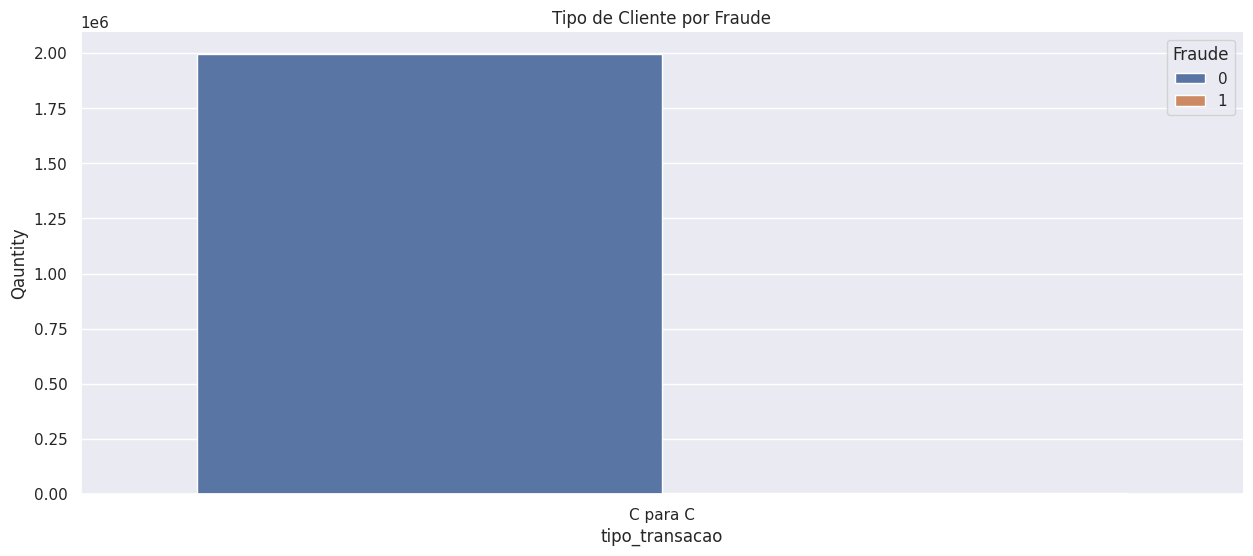

In [33]:
plt.figure(figsize=(15, 6))
sns.countplot(x='tipo_transacao', data=X_train, hue='Fraude', palette=None)
plt.title('Tipo de Cliente por Fraude')
plt.ylabel('Qauntity')
sns.despine(right=True);

### 4.3 - Análise e Visualização Multivariada

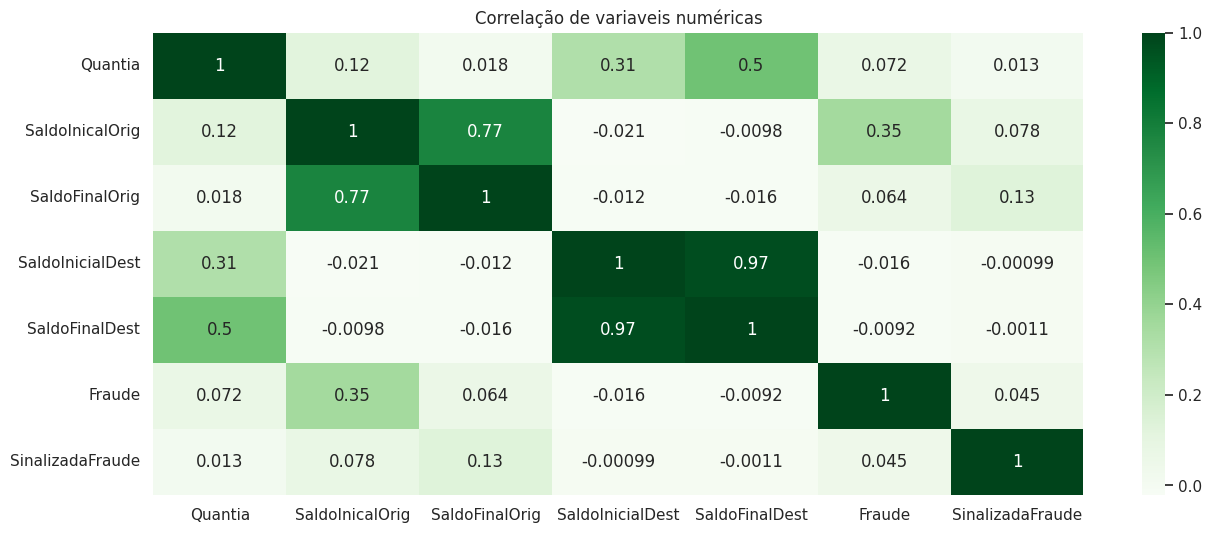

In [35]:
numerico = X_train.select_dtypes(include=['int32', 'float32'])

plt.figure(figsize=(15, 6))
sns.heatmap(numerico.corr(method='pearson'), annot=True, cmap='Greens')
plt.title('Correlação de variaveis numéricas');

* Existe uma forte correlação entre Saldo Inicial do Destino e Saldo Final do destino.
* Exite também uma correlação negativa entre Saldo Final Cliente e Saldo Inicial do destino